In [48]:
# Installing dependencies
!pip install dipy
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install scikit-image
!pip install SimpleITK


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/18.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.1 MB 660.6 kB/s eta 0:00:28
   ---------------------------------------- 0.1/18.1 MB 656.4 kB/s eta 0:00:28
   ---------------------------------------- 0.1/18.1 MB 871.5 kB/s eta 0:00:21
   ---------------------------------------- 0.1/18.1 MB 853.3 kB/s eta 0:00:22
   ---------------------------------------- 0.2/18.1 MB 841.6 kB/s eta 0:00:22
   ---------------------------------------- 0.2/18.1 MB 778.2 kB/s eta 0:00:23
    --------------------------------------- 0.2/18.1 MB 758.5 kB/s eta 0:00:24
    --------------------------------------- 0.3/18.1 MB 811.7 kB/s eta 0:00:22
    --------------------------------------- 0.3/18.1 MB 791.9 kB/s eta 0:00:23
    --------------------------------------- 0.3/18.1 MB 776.5 kB/s eta 0:00:23
    --------------------------------------- 0.4/18.1 MB 820.1 kB/s eta 0:00:22
    --------------------------------------- 0.4/18.1 MB 778.2


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Importing libraries
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [18]:
# Define function for loading nifti images
def load_nifti_files(file_paths):
    data = []
    for file_path in file_paths:
        img = nib.load(file_path)
        data.append(img.get_fdata())
    return np.array(data)

In [20]:
# Load the MRI files using nibabel
mri_file_paths = ["1.hdr"]
mri_scans = load_nifti_files(mri_file_paths)

print("Shape of MRI scans:", mri_scans.shape)

Shape of MRI scans: (1, 256, 256, 128, 1)


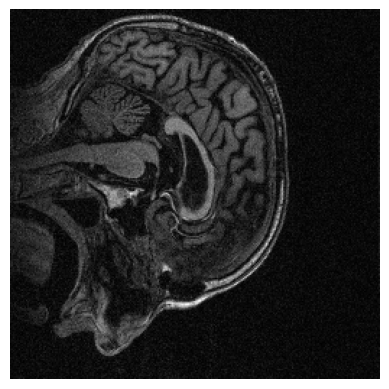

In [23]:
# Display central cross-section of each scan
import matplotlib.pyplot as plt
for scan in mri_scans:
  plt.imshow(scan[:,:,64,0], cmap="gray")
  plt.axis("off")
  plt.show()

In [28]:
# Preprocessing the data to reduce training load
def resize_image(image, new_shape):
    old_shape = np.array(image.shape)
    ratio = new_shape / old_shape
    return zoom(image, ratio, mode='nearest')

resized_scans = np.array([resize_image(scan, (128, 128, 64, 1)) for scan in mri_scans])
print("Shape of preprocessed MRI scans:", resized_scans.shape)

Shape of preprocessed MRI scans: (1, 128, 128, 64, 1)


In [29]:
# Apply histogram equalization on resized scans
from dipy.core.histeq import histeq

equalized_scans = []
for scan in resized_scans:
  data = scan[:,:,:,0]
  equalized = histeq(data)
  equalized_scans.append(equalized)

equalized_scans = np.array(equalized_scans)
print("Shape of equalized MRI scans:", equalized_scans.shape)

Shape of equalized MRI scans: (1, 128, 128, 64)


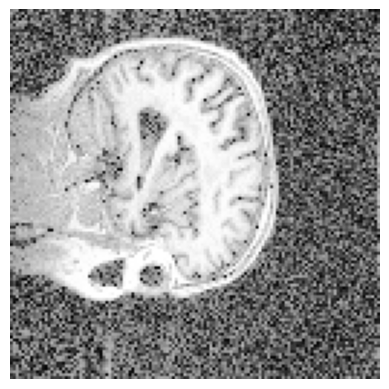

In [30]:
# Display central cross-section after histogram equalization
for scan in equalized_scans:
  plt.imshow(scan[:,:,16], cmap="gray")
  plt.axis("off")
  plt.show()

In [31]:
# Perform skull stripping on resized scans
from dipy.segment.mask import median_otsu

stripped_scans = []
for scan in equalized_scans:
  data = scan[:,:,:]
  stripped, mask = median_otsu(data, median_radius=4, numpass=2, vol_idx=range(data.shape[-1]))
  stripped_scans.append(stripped)

stripped_scans = np.array(stripped_scans)

c:\Users\infin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


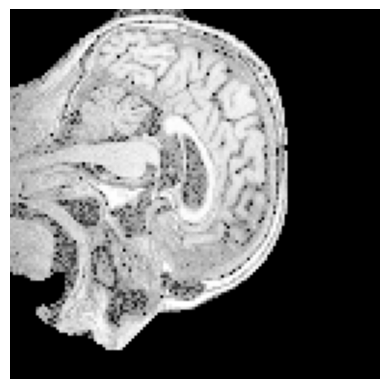

In [32]:
# Display central cross-section after skull stripping
for scan in stripped_scans:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()

In [33]:
# Perform noise reduction on stripped scans
from scipy.ndimage import gaussian_filter

def apply_noise_reduction(mri_data, sigma=1.0):
    denoised_mri_data = np.empty_like(mri_data)

    for i in range(mri_data.shape[0]):
        denoised_volume = gaussian_filter(mri_data[i, ...], sigma=sigma)
        denoised_mri_data[i, ...] = denoised_volume

    return denoised_mri_data

sigma = 0.5
denoised_mri_scans = apply_noise_reduction(stripped_scans, sigma)

print("Shape of denoised MRI scans:", denoised_mri_scans.shape)

Shape of denoised MRI scans: (1, 128, 128, 64)


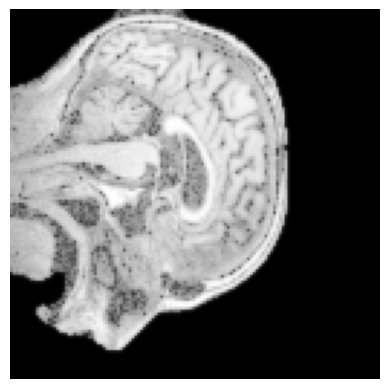

In [34]:
# Display central cross-section after noise reduction
for scan in denoised_mri_scans:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()

In [45]:
# Appying gamma correction to denoised MRI scans
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

def gamma_correction(image, gamma=1.0):
    corrected_image = exposure.adjust_gamma(image, gamma=gamma)
    return corrected_image

gamma_value = 1.5
enhanced_mri_scans_gamma = np.empty_like(denoised_mri_scans)

for i in range(denoised_mri_scans.shape[0]):
    enhanced_mri_scans_gamma[i, ...] = gamma_correction(denoised_mri_scans[i, ...], gamma=gamma_value)

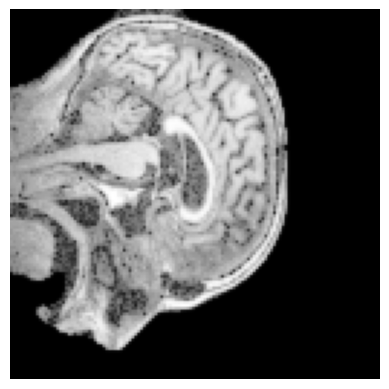

In [46]:
# Display central cross-section after gamma correction
for scan in enhanced_mri_scans_gamma:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()

In [50]:
# Applying tissue segmentation to gamma corrected images
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color

def simple_tissue_segmentation(image):

    threshold = 0.7
    segmented_image = np.zeros_like(image)
    segmented_image[image > threshold] = 1
    segmented_image[image <= threshold] = 2

    return segmented_image

segmented_mri_scans = np.empty_like(enhanced_mri_scans_gamma)

for i in range(enhanced_mri_scans_gamma.shape[0]):
    segmented_mri_scans[i, ...] = simple_tissue_segmentation(enhanced_mri_scans_gamma[i, ...])

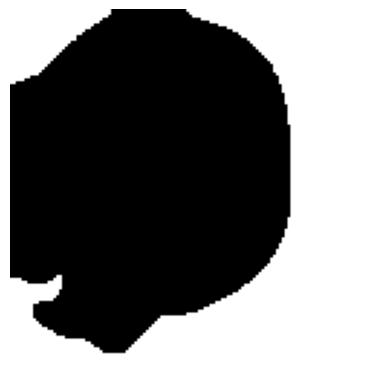

In [51]:
# Display central cross-section after gamma correction
for scan in segmented_mri_scans:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()